In [1]:
import numpy as np
from scipy.stats import norm, lognorm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append("..")
from src.dataset import CRKPTransmissionSimulator
from src.approx_bc import abc_rejection_sampler
from src.utils import get_results
from timeit import default_timer as timer
import matplotlib.gridspec as gs

In [191]:
## load data
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'

SCALE = np.array([129., 28., 38., 35., 27., 17., 95])

labels_full = ["Facility", "Floor 1", "Floor 2", "Floor 3", "Floor 4", "SCU", "Room"]

In [192]:
with open(f"{epi_dir}/observed_data.npy", "rb") as f:
            x_o = (np.load(f).T / SCALE).T

# Data Visualization

In [193]:
crkp_model = CRKPTransmissionSimulator(epi_dir, 0, 1, heterogeneous=False)
x_baseline = crkp_model.CRKP_simulator(-1e8, 100)

infections = pd.read_csv(f"{epi_dir}/infections.csv", index_col=0)
infections.columns=np.arange(53)

In [194]:
# figure out who is initially infected
T = infections.shape[1]
initial = np.zeros(T)
starting_index = infections.index[infections[0] == 1]
discharged = np.zeros(len(starting_index)).astype(bool)
for t in range(T):
    for i, ix in enumerate(starting_index):
        if discharged[i]:
            continue
        elif np.isnan(infections.loc[ix, t]):
            # print(ix, t)
            discharged[i] = True
    initial[t] = (1 - discharged).sum()

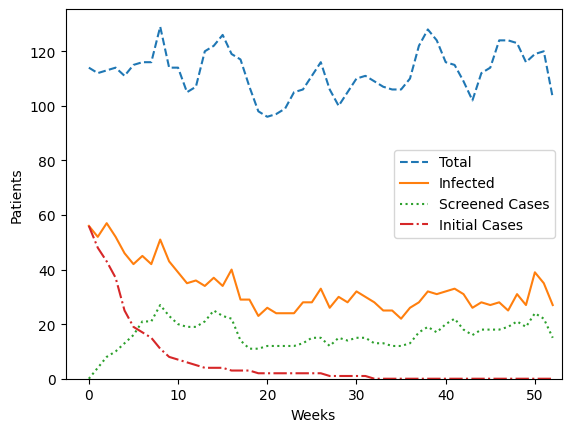

In [195]:
NN = infections.notna().sum(0)
II = (infections == 1).sum(0)
sns.lineplot(NN, linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
sns.lineplot(x_baseline * SCALE[0] - initial, linestyle=":", label="Screened Cases")
sns.lineplot(initial, linestyle="dashdot", label="Initial Cases")
plt.ylim(bottom=0)
plt.ylabel("Patients")
plt.xlabel("Weeks")
plt.savefig("images/crkp/crkp.png")
plt.xlim(right=53)
plt.show()

In [196]:
floor_pops = []
for i in [1,2,3,4,6]:
    floor_pops.append((crkp_model.F == i).sum(0))
floor_pops = np.stack(floor_pops)

floor_cases = x_o[1:6,]

In [225]:
floor_pops.mean(1)

array([20.09433962, 32.39622642, 26.30188679, 20.18867925, 13.28301887])

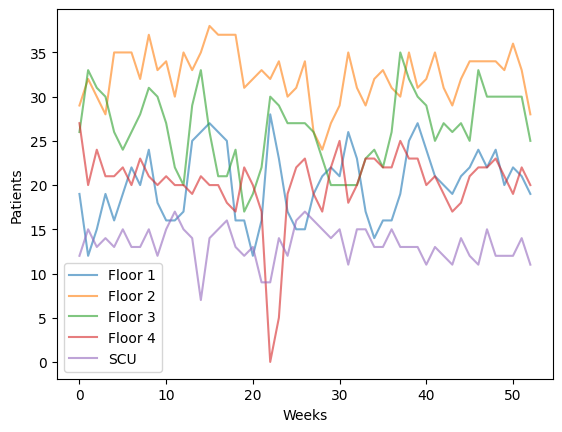

In [238]:
labels=["Floor 1", "Floor 2", "Floor 3", "Floor 4", "SCU"]
for i, label  in enumerate(labels):
    # temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    plt.plot(floor_pops[i], label=label, linestyle="-", alpha=0.6)
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Patients")
plt.savefig("images/crkp/floor_pops.png")
plt.show()

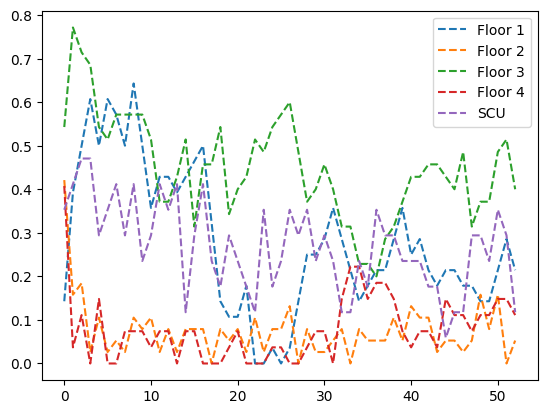

In [197]:
labels=["Floor 1", "Floor 2", "Floor 3", "Floor 4", "SCU"]
for i, label  in enumerate(labels):
    # temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    plt.plot(floor_cases[i], label=label, linestyle="--")
plt.legend()
plt.show()

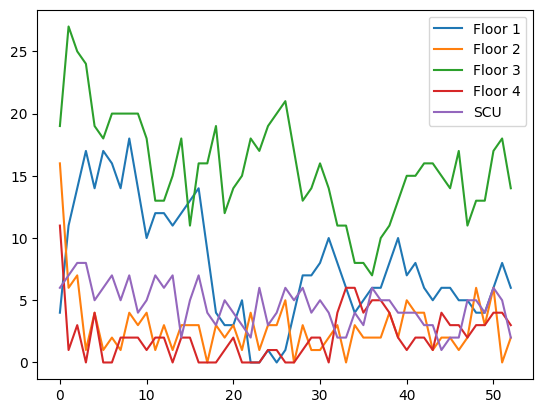

In [198]:
for i, label  in enumerate(labels):
    # temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    plt.plot(floor_cases[i] * SCALE[1:6][i], label=label)
plt.legend()
plt.show()

In [254]:
# average case burden
for i, lab in enumerate(labels):
    temp_pop = np.where(floor_pops[i] == 0, 1, floor_pops[i])
    avg_burden = np.median(floor_cases[i] * SCALE[1:6][i] / temp_pop) # median is clearer
    print(f"{lab}: {avg_burden:.2f}")

print(np.median(II / NN))

Prior Pred. Draw: 0.32
None: 0.08
None: 0.60
None: 0.10
None: 0.33
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


IndexError: index 5 is out of bounds for axis 0 with size 5

## homogeneous run

In [200]:
prior_mu = -2
prior_sigma = 1
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=False)

In [201]:
mu = -2.056
sigma = 0.124

d = norm(loc = mu, scale = sigma)
print(np.exp(d.ppf(0.05)), np.exp(d.ppf(0.95)))
print(np.exp(mu + sigma**2/2))

0.10435446582862166 0.1569170197068058
0.12895239161331243


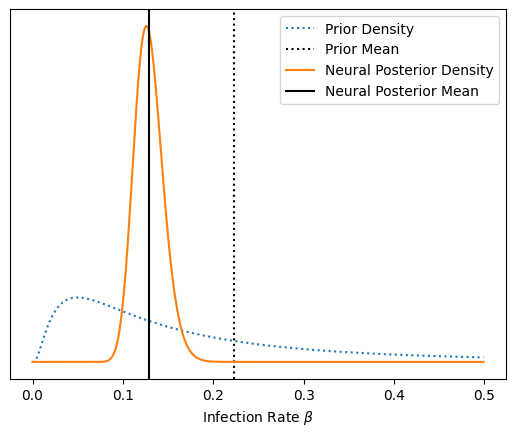

In [202]:
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
prior = norm(prior_mu, prior_sigma)
x = np.arange(0., .5, 0.001)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
ax.set_xlabel(r"Infection Rate $\beta$")
ax.set_yticks([])
plt.legend()
# plt.savefig("images/crkp_homog.png")
plt.show()

## prior predictive checks

In [203]:
prior = norm(prior_mu, prior_sigma)
K = 30
T = x_o.shape[1]
prior_sample = prior.rvs(size=K, random_state=2)
prior_predictive = np.empty((K, 7, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(prior_sample[i], i, True) * np.repeat(SCALE[:, None], T, 1)
    prior_predictive[i] =  np.array(x_rep)

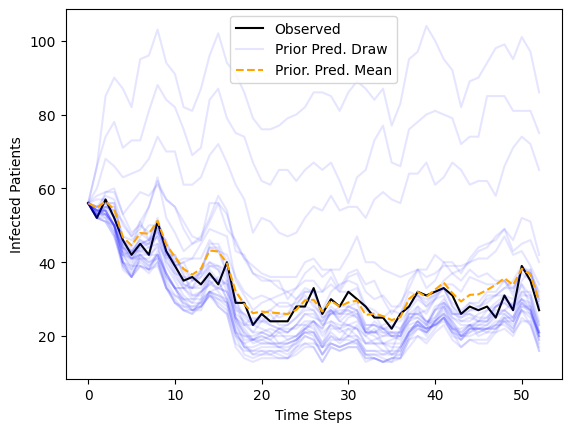

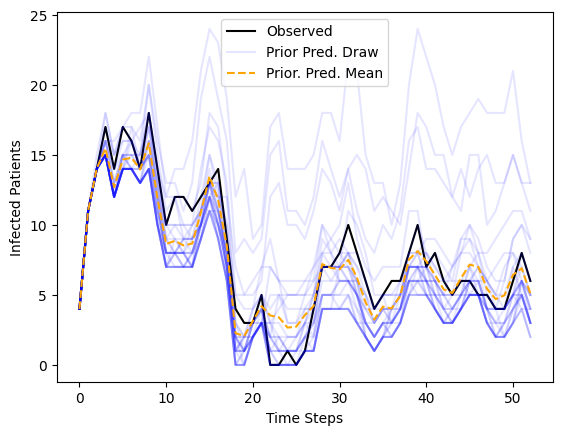

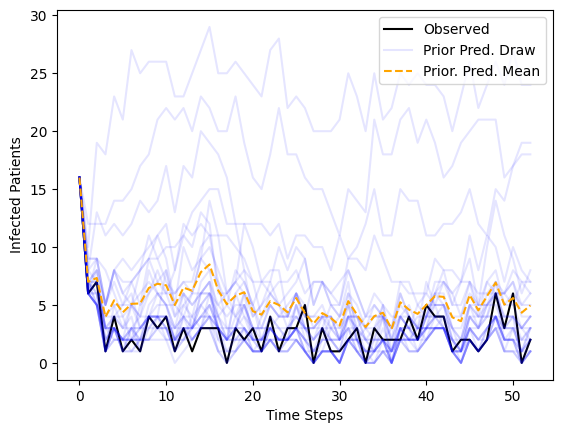

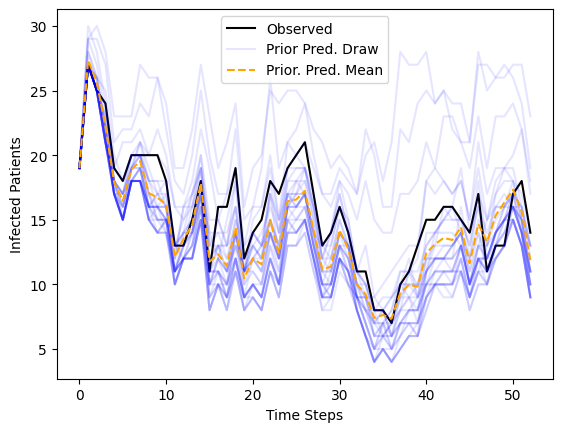

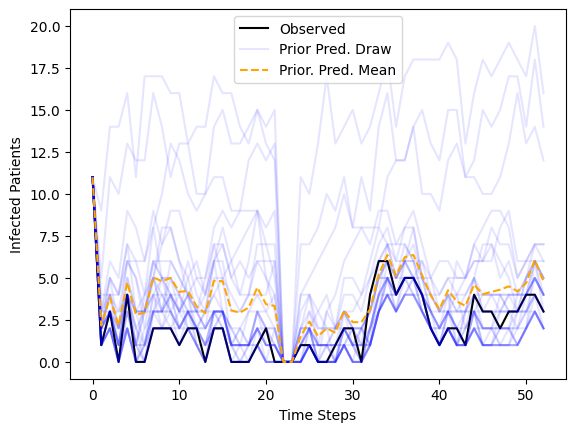

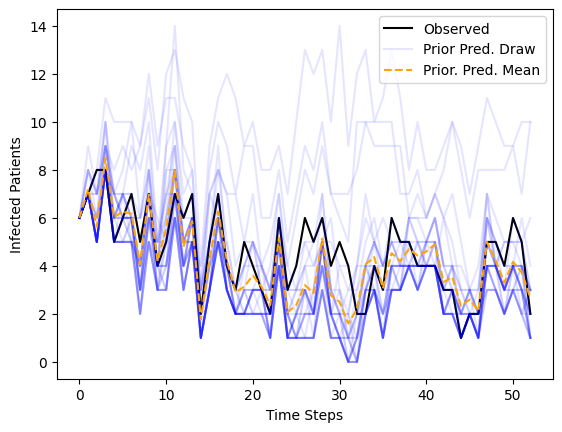

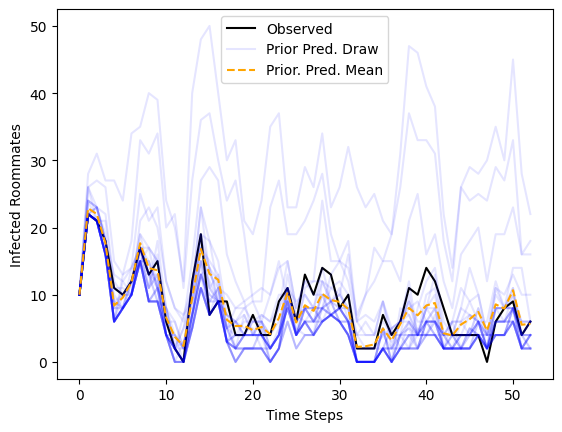

In [204]:
for j in range(7):
    pp_mean = prior_predictive.mean(0)[j]
    labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
    I_o = np.array(x_o)[j] * SCALE[j]
    plt.plot(I_o, label="Observed", color="k")
    plt.plot(prior_predictive[:, j, :].T, 
             label=labels, color="b",
             alpha=0.1)
    plt.plot(pp_mean, label="Prior. Pred. Mean", linestyle="--",
             color="orange")
    plt.legend()
    if j == 6:
        ylab = "Infected Roommates"
    else:
        ylab = "Infected Patients"
    plt.ylabel(ylab)
    plt.xlabel("Time Steps")
    # plt.savefig("images/crkp_ppc1.png")
    plt.show()

#### posterior predictive checks

In [21]:
neural_posterior = norm(mu, sigma)
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K,7,T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample[i], i, True) * np.repeat(SCALE[:, None], T, 1)
    posterior_predictive[i] =  np.array(x_rep)

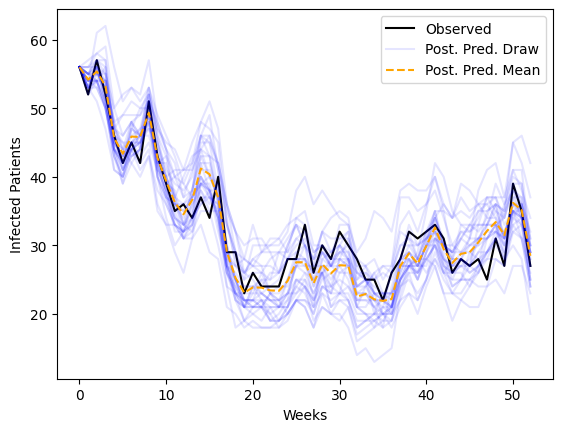

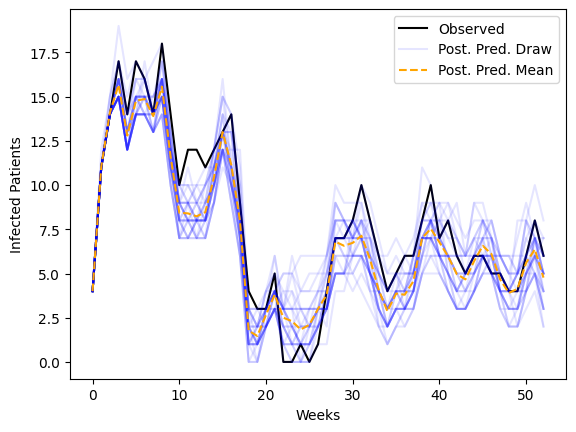

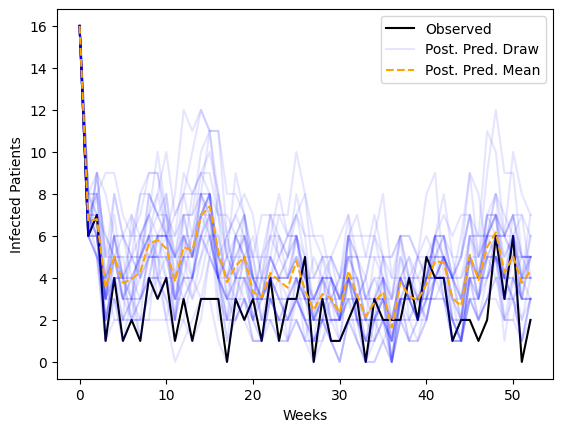

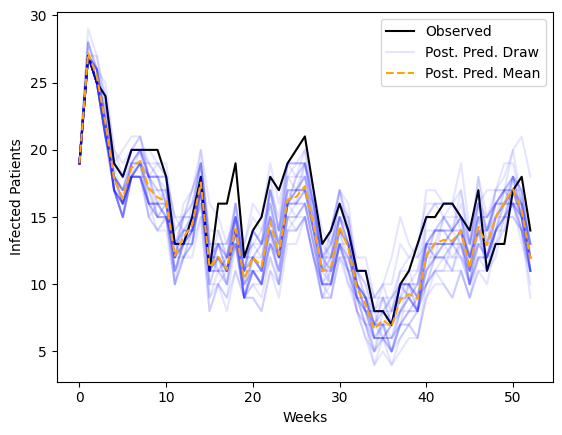

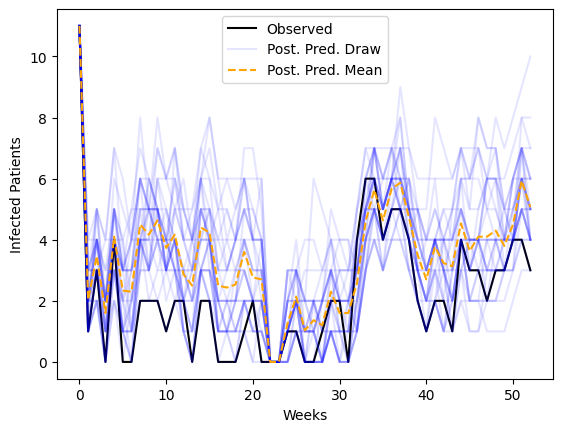

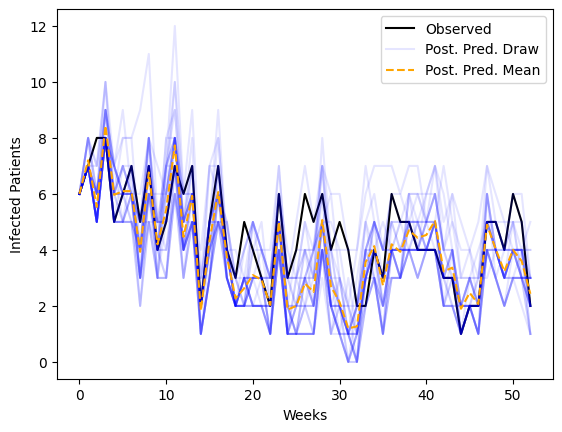

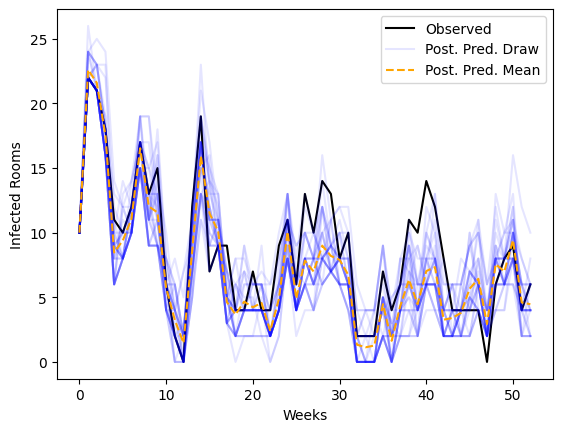

In [241]:
for j in range(7):
    pp_mean = posterior_predictive.mean(0)[j]
    labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
    I_o = np.array(x_o)[j] * SCALE[j]
    plt.plot(I_o, label="Observed", color="k")
    plt.plot(posterior_predictive[:, j, :].T, 
             label=labels, color="b",
             alpha=0.1)
    plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
             color="orange")
    plt.legend()
    if j == 6:
        ylab = "Infected Rooms"
    else:
        ylab = "Infected Patients"
    plt.ylabel(ylab)
    plt.xlabel("Weeks")
    plt.savefig(f"images/crkp/crkp_ppc_homog{j}.png")
    # plt.ylim(0, 135)
    plt.show()

## Heterogeneous

In [207]:
prior_mu = -3
prior_sigma = 1

#### prior predictive checks

In [208]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
prior_het = multivariate_normal(
    np.full((7,), prior_mu), 
    np.diag(np.full((7,), prior_sigma))
)
K = 30
T = x_o.shape[1]
prior_sample_het = prior_het.rvs(size=K, random_state=2)
prior_predictive_het = np.empty((K, 7, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(prior_sample_het[i], i) * np.repeat(SCALE[:, None], T, 1)
    prior_predictive_het[i] = np.array(x_rep)

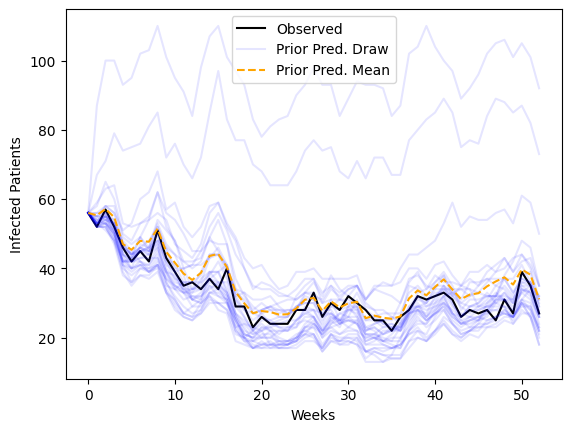

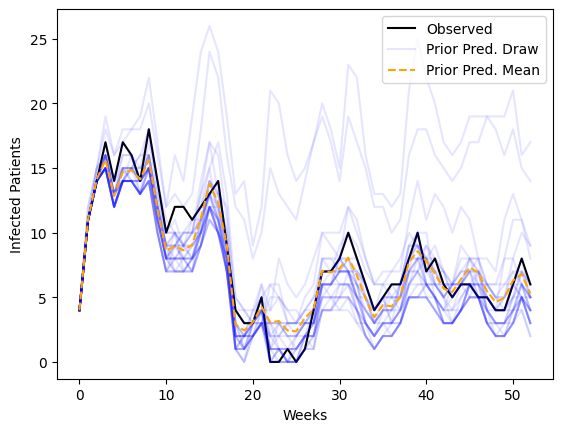

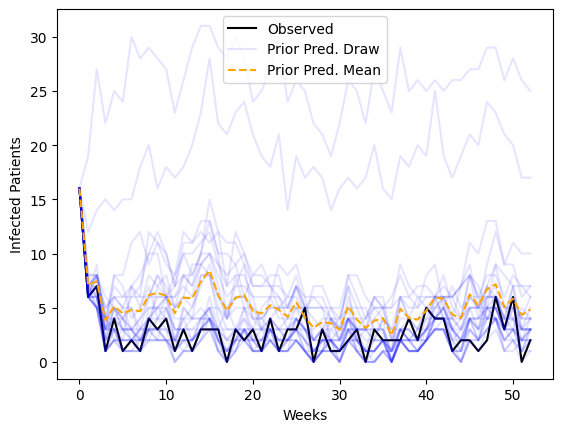

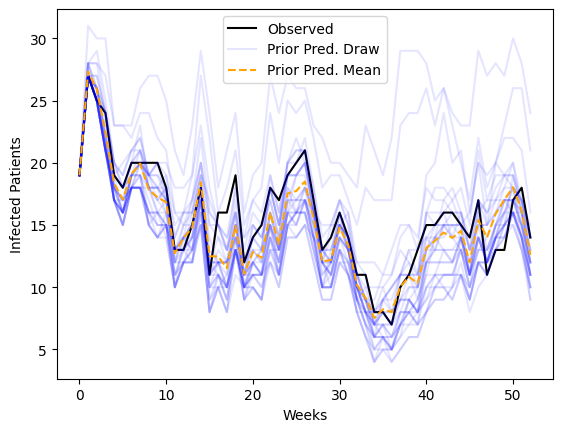

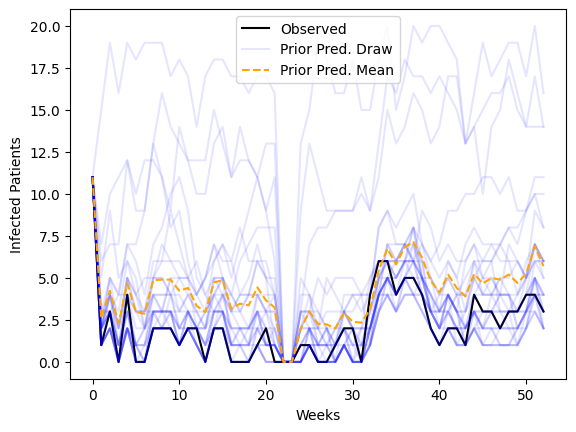

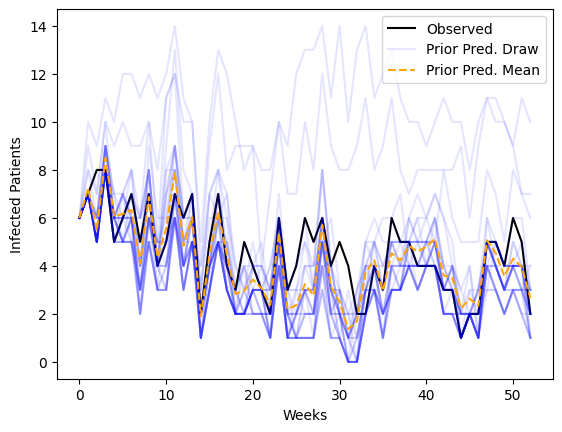

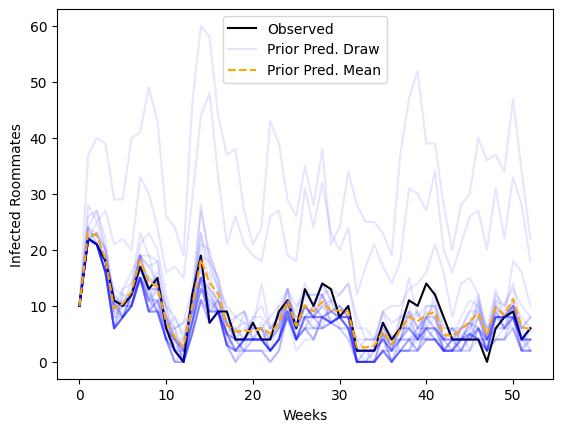

In [253]:
for j in range(7):
    pp_mean = prior_predictive_het.mean(0)[j]
    labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
    I_o = np.array(x_o)[j] * SCALE[j]
    plt.plot(I_o, label="Observed", color="k")
    plt.plot(prior_predictive_het[:, j, :].T, 
             label=labels, color="b",
             alpha=0.1)
    plt.plot(pp_mean, label="Prior Pred. Mean", linestyle="--",
             color="orange")
    plt.legend()
    if j == 6:
        ylab = "Infected Roommates"
    else:
        ylab = "Infected Patients"
    plt.ylabel(ylab)
    plt.xlabel("Weeks")
    if j == 0:
        plt.savefig(f"images/crkp/crkp_prior_pc.png")
    plt.show()

In [210]:
# get_results("../multirun/2024-12-04/15-25-57") increased variance
df_het = get_results("../multirun/2024-12-04/14-09-03") 
df_het.sort_values("val_loss", inplace=True)

In [214]:
def get_rates(df):
    j = 0
    mu = np.array(df["mu"].iloc[j][0])
    sigma = np.array(df["sigma"].iloc[j])
    rates = []
    for i in range(7):
        rates.append(np.exp(mu[i] + sigma[i][i]/2))
    return np.array(rates)

In [216]:
rates = get_rates(df_het)
rates

array([0.04195982, 0.13357426, 0.04566281, 0.13929361, 0.03366324,
       0.07170919, 0.0846332 ])

In [212]:
rates

array([0.04195982, 0.13357426, 0.04566281, 0.13929361, 0.03366324,
       0.07170919, 0.0846332 ])

In [146]:
# rough R_0 estimate
np.sum(SCALE[1:5] * rates[1:5]) / np.sum(SCALE[1:5]) + rates[0] + rates[-1]

0.21455747552333646

In [217]:
df_mf = get_results("../multirun/2024-12-04/17-58-25") 
df_mf.sort_values("val_loss", inplace=True)
get_rates(df_mf)
# in line with full covariance estimates..

array([0.04498542, 0.09508371, 0.04479157, 0.13211925, 0.02404034,
       0.06535416, 0.07263508])

#### posterior predictive checks

In [218]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
neural_posterior_het = multivariate_normal(mu, sigma)
npe_sample_het = neural_posterior_het.rvs(size=K, random_state=2)
posterior_predictive_het = np.empty((K, 7, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(npe_sample_het[i], i) * np.repeat(SCALE[:, None], T, 1) 
    posterior_predictive_het[i] =  np.array(x_rep)

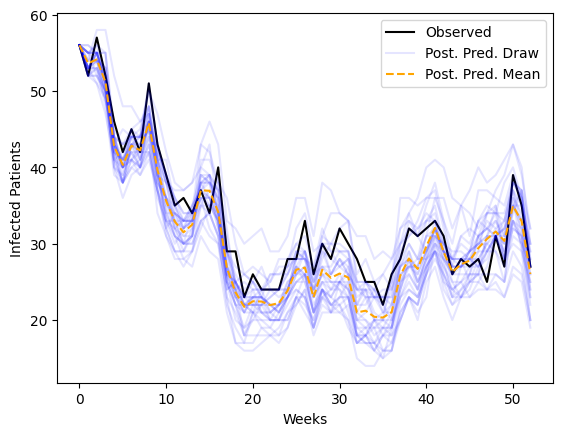

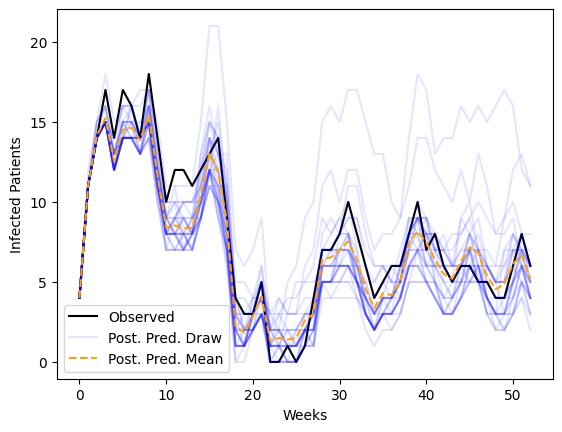

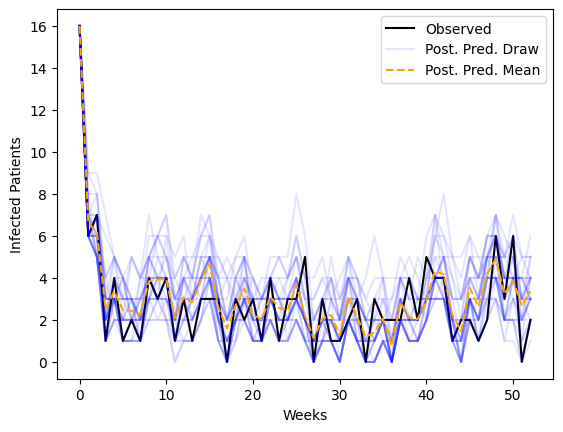

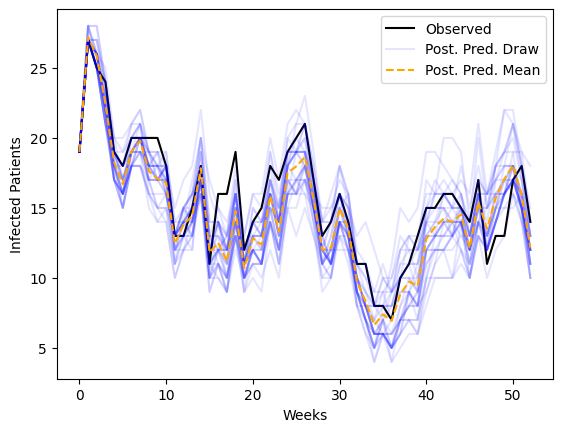

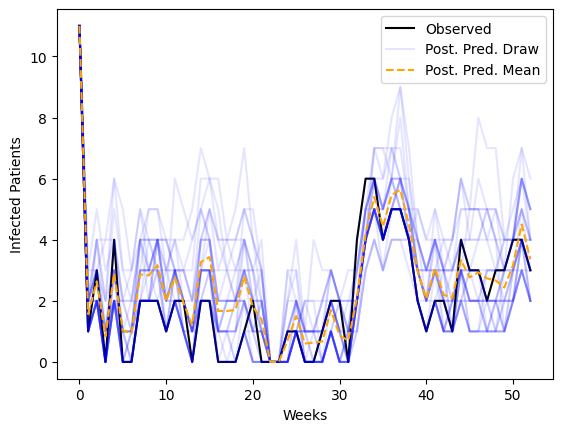

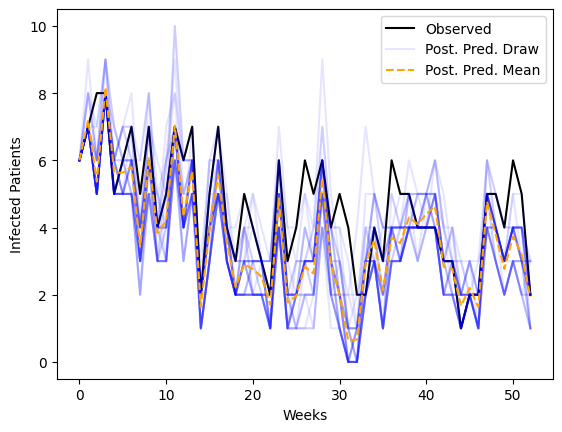

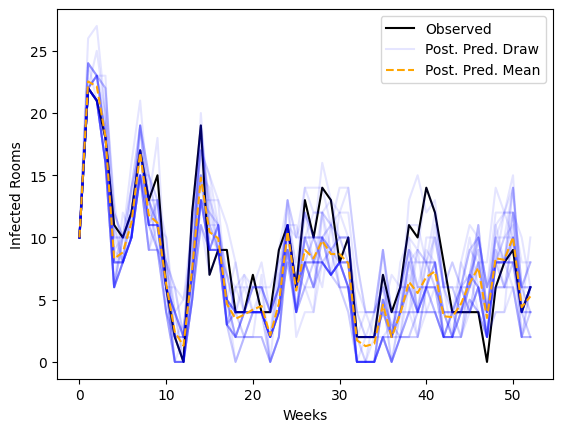

In [240]:
for j in range(7):
    pp_mean = posterior_predictive_het.mean(0)[j]
    labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
    I_o = np.array(x_o)[j] * SCALE[j]
    plt.plot(I_o, label="Observed", color="k")
    plt.plot(posterior_predictive_het[:, j, :].T, 
             label=labels, color="b",
             alpha=0.1)
    plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
             color="orange")
    # sns.lineplot(NN, color="green", linestyle="--", label="Total")
    plt.legend()
    if j == 6:
        ylab = "Infected Rooms"
    else:
        ylab = "Infected Patients"
    plt.ylabel(ylab)
    plt.xlabel("Weeks")
    plt.savefig(f"images/crkp/crkp_ppc_het{j}.png")
    plt.show()

#### comparison

In [221]:
# for j in range(7):
#     labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
#     I_o = np.array(x_o)[j] * SCALE[j]
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    
#     # Plot the first figure
#     pp_mean1 = posterior_predictive.mean(0)[j]
#     ax1.plot(I_o, label="Observed", color="k")
#     ax1.plot(posterior_predictive[:, j, :].T, 
#              label=labels, color="b",
#              alpha=0.1)
#     ax1.plot(pp_mean1, label="Post. Pred. Mean", linestyle="--",
#              color="orange")
    
#     # Plot the second figure
#     pp_mean2 = posterior_predictive_het.mean(0)[j]
#     ax2.plot(I_o, label="Observed", color="k")
#     ax2.plot(posterior_predictive_het[:, j, :].T, 
#              label=labels, color="b",
#              alpha=0.1)
#     ax2.plot(pp_mean2, label="Post. Pred. Mean", linestyle="--",
#              color="orange")

# plt.tight_layout()
# plt.show()

## Interventions

In [287]:
pis = [
    [.1, 1, 1, 1, 1, 1, 1],
    [1, .5, 1, .5, 1, 1, 1],
    [1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
]
intervention = np.empty((K, len(pis), T))
for j, pi in enumerate(pis):
    crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True, pi=pi)
    for i in range(K):
        x_rep = crkp_model.CRKP_simulator(npe_sample_het[i], i * 2)
        intervention[i,j] =  np.array(x_rep)[0] * SCALE[0]
intervention = intervention.mean(0)

array([56., 52., 57., 52., 46., 42., 45., 42., 51., 43., 39., 35., 36.,
       34., 37., 34., 40., 29., 29., 23., 26., 24., 24., 24., 28., 28.,
       33., 26., 30., 28., 32., 30., 28., 25., 25., 22., 26., 28., 32.,
       31., 32., 33., 31., 26., 28., 27., 28., 25., 31., 27., 39., 35.,
       27.])

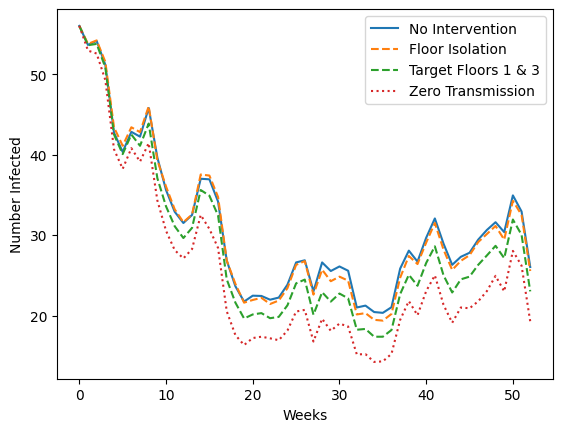

In [295]:
# plt.plot(np.array(x_o)[0] * SCALE[0], label="Observed", color="k")
plt.plot(posterior_predictive_het.mean(0)[0], label="No Intervention", linestyle="-")
plt.plot(intervention[0], label="Floor Isolation", linestyle="--")
plt.plot(intervention[1], label="Target Floors 1 & 3", linestyle="--")
plt.plot(intervention[2], label="Zero Transmission", linestyle=":")
# plt.plot(intervention[3], label="Roomies", linestyle="--")
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Number Infected")
plt.savefig("images/crkp/crkp_intervention.png")
plt.show()

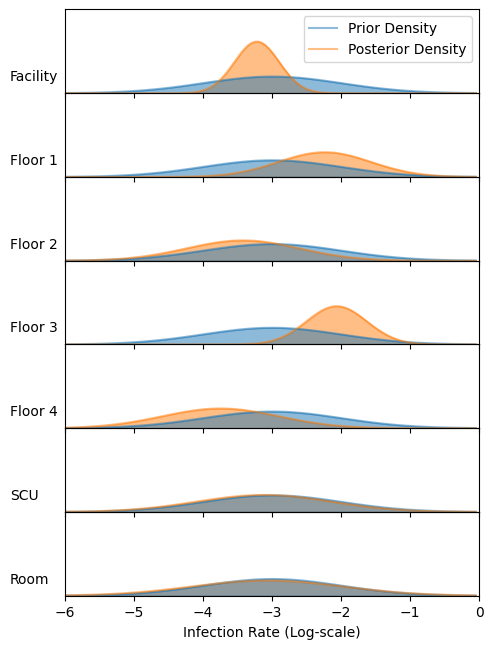

In [242]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
x_min = -6
x_max = -0
x = np.arange(x_min, x_max, 0.05)
axes = []
alpha = 0.5
for i in range(7):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu, np.sqrt(prior_sigma))
    posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(x_min, x_max)

    axes[-1].set_yticks([])

    if i < 7 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(x_min - .8, 0.3, labels_full[i])
grid.update(hspace= -.0)
plt.tight_layout()
plt.savefig("images/crkp/crkp_compare_het.png")
plt.show()
    

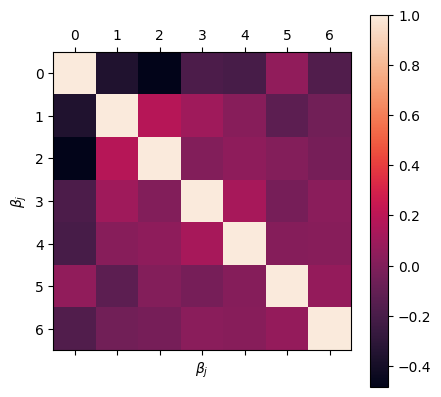

In [244]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
plt.savefig("images/crkp/crkp_corr.png")
plt.show()

## ABC Comparison

In [58]:
summarize = False #True
hetero = True

prior_mu = -3
prior_sigma = 1
model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma,
                                  heterogeneous=hetero)

In [185]:
prior_sampler = lambda: model.sample_logbeta(1)
simulator = lambda theta, seed: model.CRKP_simulator(theta, seed)

S = 100
epsilon = 1.05
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
    summarize=summarize, print_every=1000
)

Attempts: 1,000
Attempts: 2,000
Attempts: 3,000
Attempts: 4,000
Attempts: 5,000
Attempts: 6,000
Attempts: 7,000
Attempts: 8,000
Attempts: 9,000
Attempts: 10,000
Attempts: 11,000
Time lapsed: 81.16 seconds
With tolerance 1.05, acceptance rate: 0.008725
Total number of attempts: 11,461


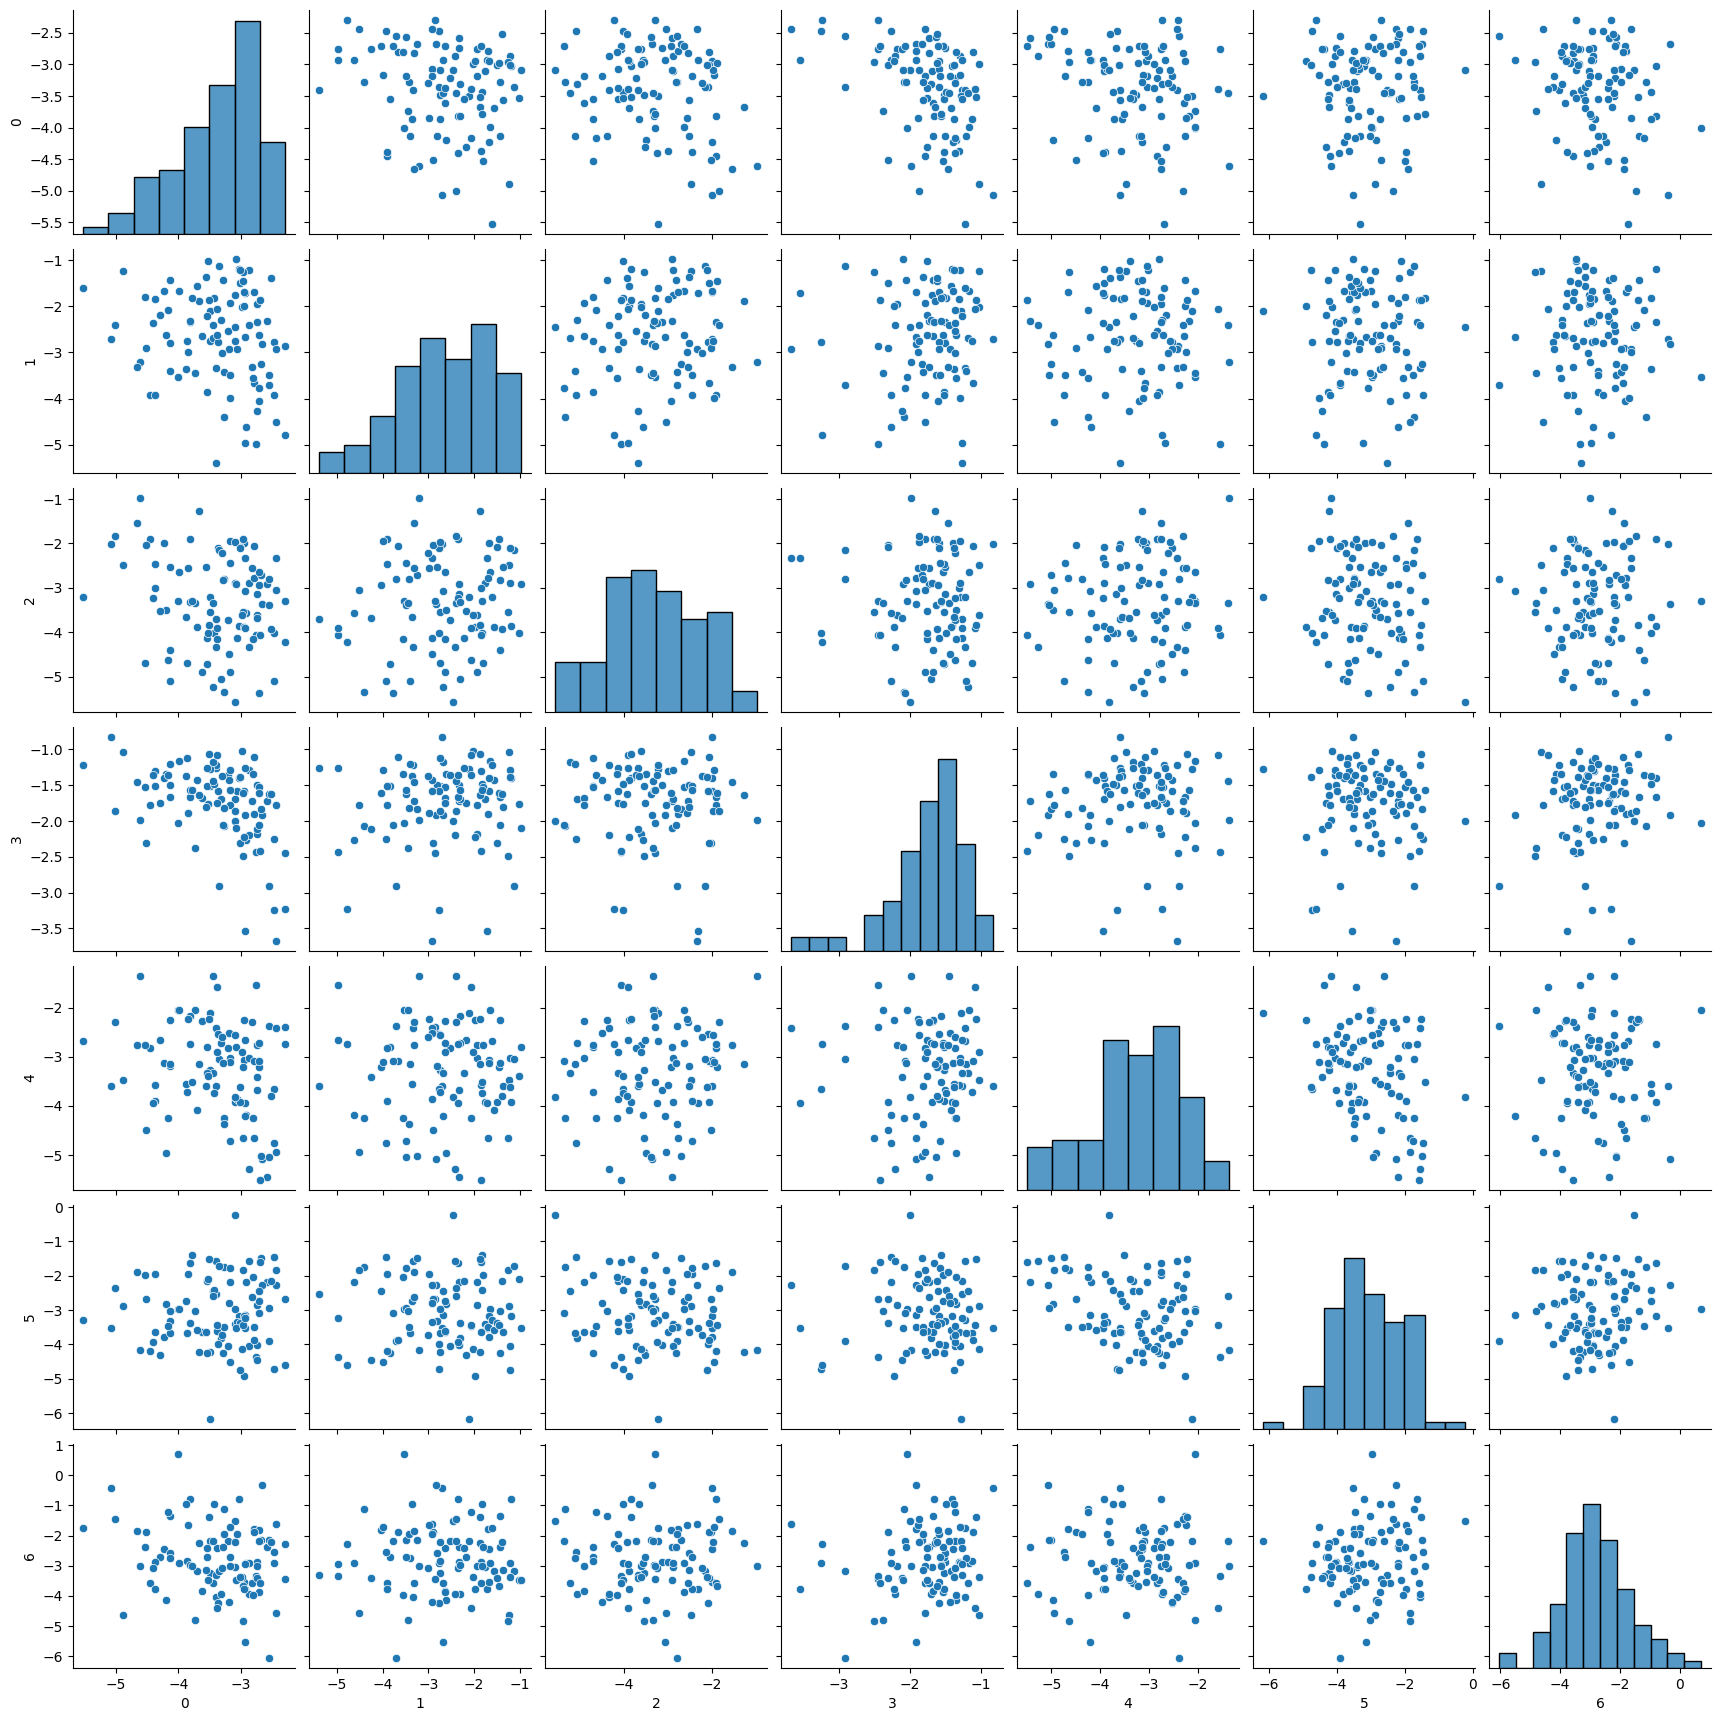

In [187]:
sns.pairplot(pd.DataFrame(posterior_sample))

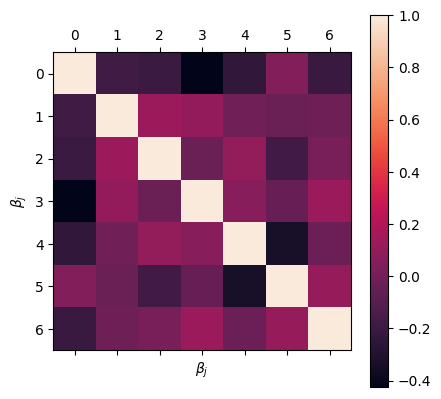

In [245]:
abc_corr = np.corrcoef(posterior_sample.T)
plt.matshow(abc_corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
plt.savefig("images/crkp/abc_corr.png")
plt.show()

In [189]:
het_table = {"Rate": labels_full, 
             "NPE Mean": np.array(rates), 
             "NPE CI": [],
            "ABC Mean": np.exp(posterior_sample).mean(0),
            "ABC CI": []}

for i in range(7):
    dist = norm(mu[i], np.sqrt(sigma[i][i]))
    het_table["NPE CI"].append(
        (np.exp(dist.ppf(0.05)), 
         np.exp(dist.ppf(0.95)))
    )
    het_table["ABC CI"].append(
        (np.quantile(np.exp(posterior_sample), 0.05, axis=0)[i],
        np.quantile(np.exp(posterior_sample), 0.95, axis=0)[i])
    )
het_table = pd.DataFrame(het_table)
print(het_table.to_latex(index=False))

\begin{tabular}{lrlrl}
\toprule
Rate & NPE Mean & NPE CI & ABC Mean & ABC CI \\
\midrule
Facility & 0.041960 & (0.023404999672593733, 0.06776490146356316) & 0.041063 & (0.009903704468160867, 0.0845945917069912) \\
Floor 1 & 0.133574 & (0.035112791822011435, 0.3225589939503908) & 0.107575 & (0.010862001357600093, 0.294265453517437) \\
Floor 2 & 0.045663 & (0.00842199423242659, 0.1259251019142028) & 0.058506 & (0.0061733817216008905, 0.1497774876654148) \\
Floor 3 & 0.139294 & (0.06184117845447551, 0.2594546866646361) & 0.196300 & (0.05462490823119879, 0.3301958784461021) \\
Floor 4 & 0.033663 & (0.005852537506686585, 0.09464521849606486) & 0.054711 & (0.006636613211594522, 0.12943407148122787) \\
SCU & 0.071709 & (0.008797635769165424, 0.22271362084468924) & 0.076421 & (0.011034087603911757, 0.21149944514036176) \\
Room & 0.084633 & (0.00767069480885153, 0.2814591934467069) & 0.123286 & (0.010331390053033828, 0.3889094859361647) \\
\bottomrule
\end{tabular}



In [158]:
np.exp(posterior_sample).mean(0)

array([0.01103   , 0.03001772, 0.03860992, 0.01765188, 0.04252731,
       0.10426845, 0.05259696], dtype=float32)

In [180]:
crkp_model = CRKPTransmissionSimulator(epi_dir, prior_mu, prior_sigma, heterogeneous=True)
# neural_posterior_het = multivariate_normal(mu, sigma)
# npe_sample_het = neural_posterior_het.rvs(size=K, random_state=2)
posterior_predictive_abc = np.empty((K, 7, T))
for i in range(K):
    x_rep = crkp_model.CRKP_simulator(posterior_sample[i], i) * np.repeat(SCALE[:, None], T, 1) 
    posterior_predictive_abc[i] =  np.array(x_rep)

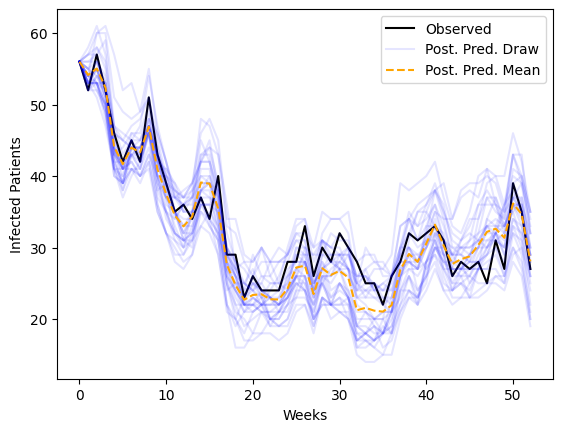

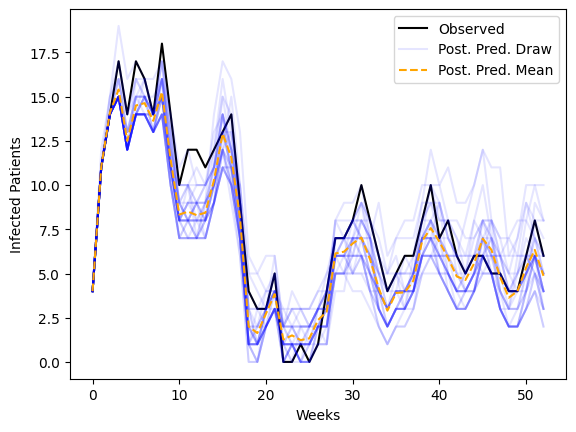

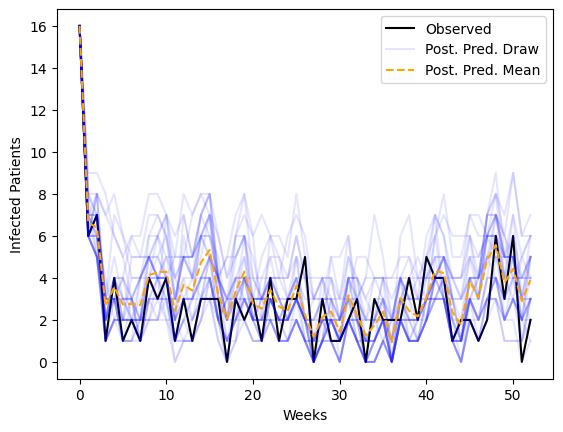

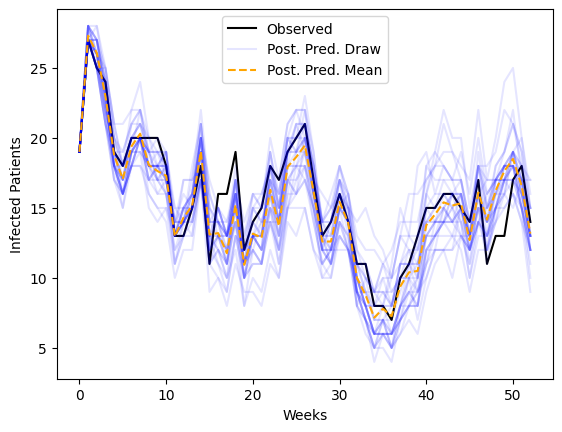

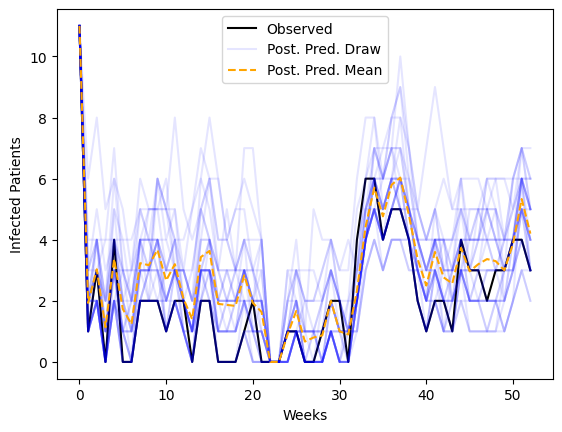

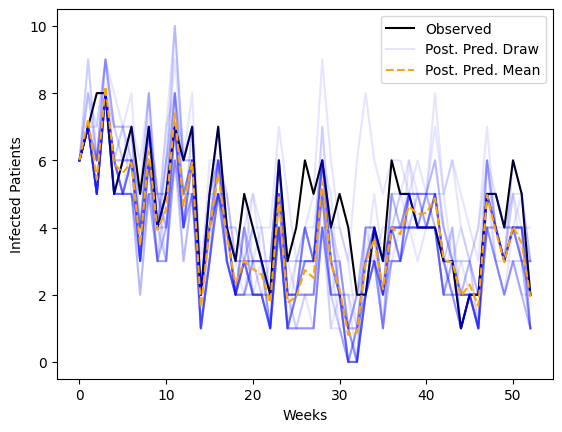

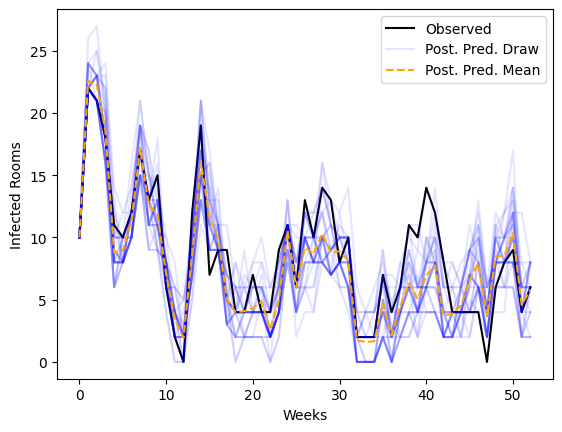

In [246]:
for j in range(7):
    pp_mean = posterior_predictive_abc.mean(0)[j]
    labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
    I_o = np.array(x_o)[j] * SCALE[j]
    plt.plot(I_o, label="Observed", color="k")
    plt.plot(posterior_predictive_abc[:, j, :].T, 
             label=labels, color="b",
             alpha=0.1)
    plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
             color="orange")
    # sns.lineplot(NN, color="green", linestyle="--", label="Total")
    plt.legend()
    if j == 6:
        ylab = "Infected Rooms"
    else:
        ylab = "Infected Patients"
    plt.ylabel(ylab)
    plt.xlabel("Weeks")
    plt.savefig(f"images/crkp/crkp_ppc_abc{j}.png")
    plt.show()

In [77]:
# abc_rates = np.exp(posterior_sample).mean(0)

# abc_lower = np.round(np.quantile(np.exp(posterior_sample), 0.05, axis=0), 3)

# abc_upper = np.round(np.quantile(np.exp(posterior_sample), 0.95, axis=0), 3)

# abc_table = {"Rate": labels_full, 
#              "Posterior Mean": np.round(np.array(abc_rates), 3), 
#              "CI": []}

# for i in range(7):
#     abc_table["CI"].append((abc_lower[i], abc_upper[i]))

# abc_table = pd.DataFrame(abc_table)
# print(abc_table.to_latex(index=False))

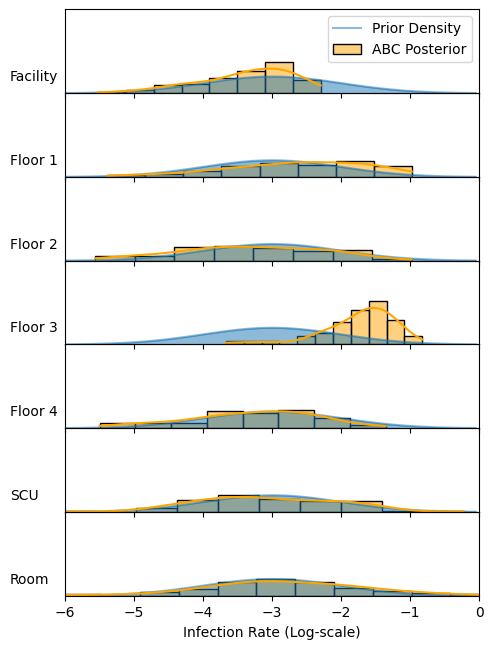

In [250]:
grid = gs.GridSpec(8, 1)
fig = plt.figure(figsize=(5,7))
xmin, xmax = -6, 0

x = np.arange(xmin, xmax, 0.05)
axes = []
alpha = 0.5
for i in range(7):
    legend = False if i > 0 else True
    axes.append(fig.add_subplot(grid[i:i+1, 0:]))

    priory = norm.pdf(x, prior_mu, np.sqrt(prior_sigma))
    # posty = norm.pdf(x, mu[i], np.sqrt(sigma[i][i]))
    sns.lineplot(x=x, y=priory, label="Prior Density", ax=axes[-1], legend=legend, alpha=alpha)

    sns.histplot(posterior_sample[:, i], color="orange", ax=axes[-1], legend=legend, alpha=alpha, stat="density",
                kde=True, label="ABC Posterior")

    post_mean = np.mean(posterior_sample[:, i])

    # plt.axvline(post_mean, color="k", linestyle="--")

    # sns.lineplot(x=x, y=posty, label="Posterior Density", ax=axes[-1], legend=legend, alpha=alpha)

    rect = axes[-1].patch
    rect.set_alpha(0)

    axes[-1].set_yticklabels([])
    axes[-1].set_ylabel('')

    axes[-1].set_ylim(0, 2)
    axes[-1].set_xlim(xmin, xmax)

    axes[-1].set_yticks([])

    if i < 7 - 1:
        axes[-1].set_xticklabels([])
    else:
        axes[-1].set_xlabel("Infection Rate (Log-scale)")

    # axes[-1].fill_between(x, posty, color='#ff7f0e', alpha=alpha)
    axes[-1].fill_between(x, priory, color='#1f77b4', alpha=alpha)


    axes[-1].text(x_min - 0.8, 0.3, labels_full[i])

    if i == 0:
        plt.legend()
grid.update(hspace= -.0)
plt.tight_layout()
plt.savefig("images/crkp/crkp_compare_abc.png")
plt.show()